In [ ]:
!unzip videos.zip
!unzip normal.zip
!unzip emotional.zip

Archive:  videos.zip
   creating: videos/
  inflating: videos/1 (0,2).mp4      
  inflating: videos/10 (0,25).mp4    
  inflating: videos/100 (0,1).mp4    
  inflating: videos/11 (0,25).mp4    
  inflating: videos/12 (0,25).mp4    
  inflating: videos/13 (0,25).mp4    
  inflating: videos/14 (0,25).mp4    
  inflating: videos/15 (0,25).mp4    
  inflating: videos/16 (0,25).mp4    
  inflating: videos/17 (0,25).mp4    
  inflating: videos/18 (0,25).mp4    
  inflating: videos/19 (0,25).mp4    
  inflating: videos/2 (0,25).mp4     
  inflating: videos/20 (0,25).mp4    
  inflating: videos/21 (0,25).mp4    
  inflating: videos/22 (0,25).mp4    
  inflating: videos/23 (0,25).mp4    
  inflating: videos/24 (0,25).mp4    
  inflating: videos/25 (0,15).mp4    
  inflating: videos/26 (0,25).mp4    
  inflating: videos/27 (0,2).mp4     
  inflating: videos/28 (0,2).mp4     
  inflating: videos/29 (0,2).mp4     
  inflating: videos/3 (0,25).mp4     
  inflating: videos/30 (0,2).mp4     
  inflat

In [2]:
!pip install hsemotion
!pip install mediapipe

In [4]:
import pandas as pd
import os
import cv2
import mediapipe as mp
import numpy as np
from hsemotion.facial_emotions import HSEmotionRecognizer
import torch
from PIL import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import seaborn as sns
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from datetime import datetime, date
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn import tree
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from copy import deepcopy
from sklearn.inspection import permutation_importance
from sklearn import linear_model
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from adjdatatools.preprocessing import AdjustedScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score as r2
from joblib import dump
from joblib import load

TypeError: validate_params() got an unexpected keyword argument 'prefer_skip_nested_validation'

In [6]:
face_mesh = mp.solutions.face_mesh.FaceMesh()
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
model_name='enet_b0_8_best_afew'
fer=HSEmotionRecognizer(model_name=model_name,device=device)

C:\Users\Operator\.hsemotion\enet_b0_8_best_afew.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.3)
def get_main_face(frame):
  results = face_detection.process(frame)
  main_face = None
  max_score = 0
  if results.detections is not None:
    for detection in results.detections:
        if detection.score[0] > max_score:
            main_face = detection
            max_score = detection.score[0]
    if main_face is not None:
      bbox = main_face.location_data.relative_bounding_box
      image_height, image_width, _ = frame.shape
      x, y, w, h = int(bbox.xmin * image_width), int(bbox.ymin * image_height), \
                  int(bbox.width * image_width), int(bbox.height * image_height)
      main_face = frame[y:y+h, x:x+w]
      #cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
  return main_face

In [8]:
def get_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

In [9]:
def process_frame_every_n(frames, n):
    imgs = frames[::n]
    faces = list(map(get_main_face, imgs))
    emotions,scores = [], []
    for face in faces:
      if face is not None:
        try:
          emotion,score=fer.predict_emotions(face,logits=False)
          emotions.append(emotion)
          scores.append(score)
        except Exception:
          continue
    return emotions, scores

In [10]:
# @title Расчет процентного соотношения пребывания каждой эмоции в списке эмоций
def calculate_emotion_percentage(emotion_list):
    total_frames = len(emotion_list)
    emotion_percentage = {}
    for emotion in emotion_list:
        if emotion in emotion_percentage.keys():
            emotion_percentage[emotion] += 1
        else:
            emotion_percentage[emotion] = 1
    for emotion in emotion_percentage.keys():
        emotion_percentage[emotion] = (emotion_percentage[emotion] / total_frames) * 100

    return emotion_percentage

In [11]:
# @title Подсчет частоты изменения эмоций
def calculate_emotion_change_frequency(emotion_list):
    total_frames = len(emotion_list)
    emotion_changes = 0
    for i in range(1, total_frames):
        if emotion_list[i] != emotion_list[i-1]:
            emotion_changes += 1
    emotion_change_frequency = emotion_changes / total_frames
    return emotion_change_frequency

In [12]:
def get_subarray(array, subset, ind):
  last_ind = min(ind+subset, len(array))
  return array[ind:last_ind]

In [13]:
def count_values(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = get_all_frames(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  total_frames = len(frames)
  video_duration_sec = total_frames / fps
  frames_per_second = int(total_frames // video_duration_sec)
  emotion_results = []
  for i in range(0, total_frames, frames_per_second):
    second_frames = get_subarray(frames, frames_per_second, i)
    emotions, scores = process_frame_every_n(second_frames, 1)
    percentages = calculate_emotion_percentage(emotions)
    try:
      max_emotion = max(percentages, key=percentages.get)
      emotion_results.append(max_emotion)
    except Exception as ex:
      print(ex.args[0])
      emotion_results.append('emotion not determined')
  return emotion_results

In [14]:
dictionary = {'Sadness':[], 'Disgust':[], 'Fear':[], 'Neutral':[], 'Happiness':[], 'Suprise':[], 'Anger':[], 'Contempt':[]}

In [15]:
from tqdm import tqdm

In [17]:
dir_paths = ['videos/', 'normal/', 'emotional/']
paths = []
values = []
freq = []
for dir_path in dir_paths:
    all_files = os.listdir(dir_path)
    for file in tqdm(all_files):
        path = os.path.join(dir_path, file)
        value = file.split("(", 1)[1].split(")", 1)[0]
        value = float(value.replace(",", "."))
        res = count_values(path)
        percentage = calculate_emotion_percentage(res)
        for key in dictionary.keys():
          if key in percentage.keys():
            dictionary[key].append(percentage[key])
          else:
            dictionary[key].append(0)
        frequency = calculate_emotion_change_frequency(res)
        freq.append(frequency)
        values.append(value)
        paths.append(path)
    res = pd.DataFrame()
    res['path'] = paths
    res['values'] = values
    res['freq'] = freq
    for key in dictionary.keys():
        res[key] = dictionary[key]
    res.to_csv(f'{dir_path}.csv', index=False, encoding='utf-8')
    

 36%|███████████████████████████▋                                                 | 36/100 [1:08:35<1:24:39, 79.37s/it]

max() arg is an empty sequence


 50%|███████████████████████████████████████▌                                       | 50/100 [1:20:27<41:34, 49.88s/it]

max() arg is an empty sequence


 51%|████████████████████████████████████████▎                                      | 51/100 [1:20:59<36:16, 44.42s/it]

max() arg is an empty sequence


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:07:37<00:00, 76.58s/it]


In [18]:
df = pd.read_csv('emotional/.csv')

In [19]:
df

,path,values,freq,Sadness,Disgust,Fear,Neutral,Happiness,Suprise,Anger,Contempt
0,"videos/1 (0,2).mp4",0.20,0.363636,9.090909,0.000000,0.000000,9.090909,0.0,0,0.000000,81.818182
1,"videos/10 (0,25).mp4",0.25,0.090909,18.181818,0.000000,0.000000,0.000000,0.0,0,81.818182,0.000000
2,"videos/100 (0,1).mp4",0.10,0.000000,0.000000,0.000000,0.000000,100.000000,0.0,0,0.000000,0.000000
3,"videos/11 (0,25).mp4",0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,100.000000,0.000000
4,"videos/12 (0,25).mp4",0.25,0.181818,18.181818,0.000000,0.000000,0.000000,0.0,0,81.818182,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
295,"emotional/95 (0,8).mp4",0.80,0.272727,0.000000,9.090909,0.000000,0.000000,0.0,0,81.818182,0.000000
296,"emotional/96 (0,8).mp4",0.80,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0,90.909091,0.000000
297,"emotional/97 (0,85).mp4",0.85,0.272727,0.000000,0.000000,9.090909,0.000000,0.0,0,81.818182,0.000000
298,"emotional/98 (0,75).mp4",0.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,100.000000,0.000000


C:\Users\Operator\AppData\Local\Temp\ipykernel_5912\4076047204.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<Axes: >

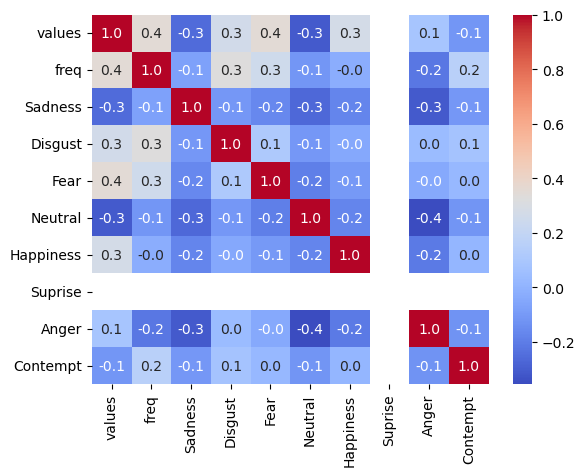

In [24]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")

In [27]:
df = df.drop(columns=['Suprise'])

In [28]:
df.head()

,path,values,freq,Sadness,Disgust,Fear,Neutral,Happiness,Anger,Contempt
0,"videos/1 (0,2).mp4",0.20,0.363636,9.090909,0.0,0.0,9.090909,0.0,0.000000,81.818182
1,"videos/10 (0,25).mp4",0.25,0.090909,18.181818,0.0,0.0,0.000000,0.0,81.818182,0.000000
2,"videos/100 (0,1).mp4",0.10,0.000000,0.000000,0.0,0.0,100.000000,0.0,0.000000,0.000000
3,"videos/11 (0,25).mp4",0.25,0.000000,0.000000,0.0,0.0,0.000000,0.0,100.000000,0.000000
4,"videos/12 (0,25).mp4",0.25,0.181818,18.181818,0.0,0.0,0.000000,0.0,81.818182,0.000000


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 2:], df['values'], random_state=42, test_size=0.15)

In [33]:
clf = KNeighborsRegressor()
ridge = Ridge()
reg = GradientBoostingRegressor()
tree_clf = ExtraTreesRegressor()
lasso = linear_model.Lasso()

In [34]:
grid_search_dict = {
    'KNN' : GridSearchCV(estimator = clf, cv = 5,
                 param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 15], 'p': [1, 2]},
                 scoring = 'neg_mean_squared_error'),
    'Ridge regression' :GridSearchCV(estimator = ridge, cv = 5,
                 param_grid = {'alpha': [1, 0.01, 0.001, 0.0001, 1.5, 2], 'max_iter': [500, 1000, 2000]},
                 scoring = 'neg_mean_squared_error'),
    'Boosting' : GridSearchCV(estimator = reg, cv =5,
                 param_grid = {"learning_rate":[0.3, 0.1, 0.03],
                              "n_estimators":[50, 100, 200], 'max_depth': [1, 5, 7, 10]},
                 scoring = 'neg_mean_squared_error'),
    'Decision tree': GridSearchCV(estimator = tree_clf, cv = 5,
                 param_grid = {'max_depth': [None, 10, 50], 'criterion' :
                               ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},
                 scoring = 'neg_mean_squared_error'),
    'Lasso regression' : GridSearchCV(estimator = lasso, cv = 5,
             param_grid = {'alpha': [1, 0.01, 0.001, 0.0001, 1.5, 2], 'max_iter': [500, 1000, 2000]},
             scoring = 'neg_mean_squared_error')
}

  0%|          | 0/5 [00:00<?, ?it/s]

KNN -0.04275411764705882 {'n_neighbors': 5, 'p': 1}
test mse: 0.03606
r2: 0.5538355787737146
Ridge regression -0.04879020719668868 {'alpha': 0.01, 'max_iter': 500}
test mse: 0.04451144403499291
r2: 0.44926725829676084
Boosting -0.039525625439554145 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
test mse: 0.0302914551999247
r2: 0.6252088303556196
Decision tree -0.037248043364544514 {'criterion': 'poisson', 'max_depth': 10}
test mse: 0.025658167316522068
r2: 0.6825357357042912
Lasso regression -0.04879073118881126 {'alpha': 0.0001, 'max_iter': 500}
test mse: 0.04452397761191644
r2: 0.44911218242061046


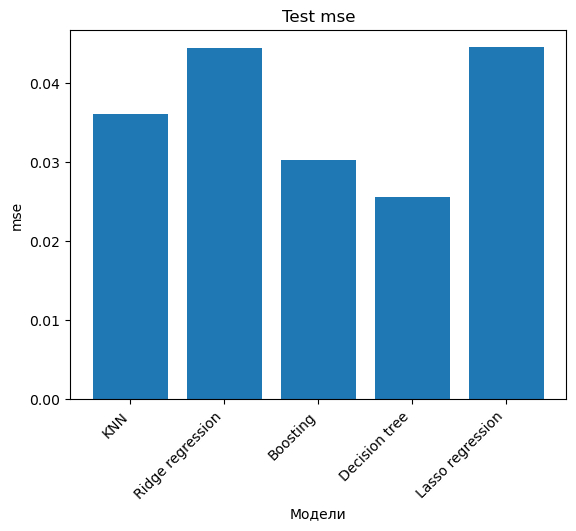

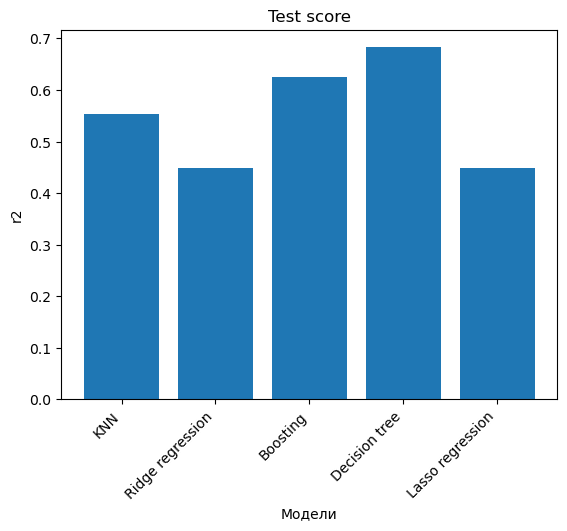

In [35]:
result = {}
result_score = {}
for model in tqdm(grid_search_dict.keys()):
    mod = grid_search_dict[model].fit(X_train, y_train)
    print(model, mod.best_score_, mod.best_params_)
    pred = mod.predict(X_test)
    t_m = mse(pred, y_test)
    print('test mse:', t_m)
    result[model] = t_m
    score = r2(y_test, pred)
    print('r2:', score)
    result_score[model] = score
keys = list(result.keys())
values = list(result.values())
plt.bar(keys, values)
plt.xlabel('Модели')
plt.ylabel('mse')
plt.title('Test mse')
plt.xticks(rotation=45, ha='right')
plt.show()
    
keys = list(result_score.keys())
values = list(result_score.values())
plt.bar(keys, values)
plt.xlabel('Модели')
plt.ylabel('r2')
plt.title('Test score')
plt.xticks(rotation=45, ha='right')
plt.show()

In [38]:
dump(grid_search_dict['Decision tree'], 'model.joblib')

['model.joblib']

In [39]:
loaded_model = load('model.joblib')
pred = loaded_model.predict(X_test)
r2(y_test, pred)

0.6825357357042912

In [51]:
X_test.columns

Index(['freq', 'Sadness', 'Disgust', 'Fear', 'Neutral', 'Happiness', 'Anger',
       'Contempt'],
      dtype='object')

In [56]:
arr = [[0.0, 0.0, 0.0, 100.0,0.0, 0.0, 0.0, 0.0]]
loaded_model.predict(arr)[0]

C:\Users\Operator\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


0.7104919662215949